<a href="https://colab.research.google.com/github/ntontonto/kaggle/blob/mitty_branch/house-price/model_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 特徴量のカンペはこちら ⇒ https://docs.google.com/spreadsheets/d/1T59ieP110cFg8MfOtIbW2M60iWuSwnIf/edit?usp=share_link&ouid=111727008586725963366&rtpof=true&sd=true

## Kaggle用データのインポート

In [1]:
from google.colab import drive
drive.mount('/content/drive')

COMPETITION = "house-prices-advanced-regression-techniques"
WORK_DIR = "/content/drive/MyDrive/Colab Notebooks/kaggle"

import os

if not(os.path.exists(WORK_DIR)):
  os.mkdir(WORK_DIR)
os.chdir(WORK_DIR)

from google.colab import files
files.upload()

Mounted at /content/drive


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rmkenshirou","key":"40ef74c07bbc84fc4d23d8dc8dc7c1f8"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c {COMPETITION} # copy from competition page!
!unzip -o {COMPETITION}
!rm {COMPETITION}.zip

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 37.6MB/s]
Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## ライブラリのインポート

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from numpy import mean, std
!pip install tensorflow_decision_forests
!pip install optuna
import optuna
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import statsmodels.formula.api as smf
from statsmodels.stats import power
import statsmodels.api as sm
from scipy import stats
import math
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.metrics import mean_squared_error

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import math

PALETTE=['lightcoral', 'lightskyblue', 'gold', 'sandybrown', 'navajowhite',
        'khaki', 'lightslategrey', 'turquoise', 'rosybrown', 'thistle', 'pink']
sns.set_palette(PALETTE) # seabornのデフォルトの色を変更する
BACKCOLOR = '#f6f5f5'

from scipy.special import boxcox1p
from IPython.core.display import HTML
from scipy.stats import norm, skew #for some statistics
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedKFold
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

from sklearn.neighbors import LocalOutlierFactor
from sklearn.base import BaseEstimator, TransformerMixin
from copy import deepcopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 76.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.4 MB/s eta 0:00:00


### User modules

In [4]:
# 並び替え検定用の関数
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()

In [5]:
# permutation test
def permutation_test(data, var, target):

  vA = data[var].dropna().unique()[0]
  vB = data[var].dropna().unique()[1]
  mean_a = data[data[var] == vA][target].mean()
  mean_b = data[data[var] == vB][target].mean()
  print(f"{target} mean value with {var}={vA}: {mean_a}")
  print(f"{target} mean value with {var}={vB}: {mean_b}")
  print(f"{target} observed difference between ({var}={vA}) and ({var}={vB}): {mean_b - mean_a}")
  nA = data[data[var] == vA].shape[0]
  nB = data[data[var] == vB].shape[0]

  random.seed(1)
  perm_diffs = pd.Series([perm_fun(data[target], nA, nB) for _ in range(1000)])
  perm_diffs = perm_diffs.dropna()

  fig, ax = plt.subplots(figsize=(5, 5))
  ax.hist(perm_diffs, bins=11, rwidth=0.9)
  ax.axvline(x = mean_b - mean_a, color='black', lw=2)
  ax.text(mean_b - mean_a, 10, 'Observed\ndifference', bbox={'facecolor':'white'})
  ax.set_xlabel(f'{var} differences')
  ax.set_ylabel('Frequency')

  plt.tight_layout()
  plt.show()

  perm_diffs = np.array(perm_diffs)
  print('p-value: ', (np.mean(perm_diffs > mean_b - mean_a)))

In [6]:
def multi_table(table_list):
    return HTML(
        f"<table><tr> {''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list])} </tr></table>")

In [7]:
def cat_dist(data, var, hue, msg_show=True):
    total_cnt = data[var].count()
    f, ax = plt.subplots(1, 2, figsize=(25, 8))
    hues = [None, hue]
    titles = [f"{var}'s distribution", f"{var}'s distribution by {hue}"]

    for i in range(2):
        sns.countplot(data[var], edgecolor='black', hue=hues[i], linewidth=1, ax=ax[i], data=data)
        ax[i].set_xlabel(var, weight='bold', size=13)
        ax[i].set_ylabel('Count', weight='bold', size=13)
        ax[i].set_facecolor(BACKCOLOR)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].set_title(titles[i], size=15, weight='bold')
        for patch in ax[i].patches:
            x, height, width = patch.get_x(), patch.get_height(), patch.get_width()
            if msg_show:
                ax[i].text(x + width / 2, height + 3, f'{height} \n({height / total_cnt * 100:2.2f}%)', va='center', ha='center', size=12, bbox={'facecolor': 'white', 'boxstyle': 'round'})
    plt.show()

In [8]:
def continuous_dist(data, x, y):
    f, ax = plt.subplots(1, 4, figsize=(35, 10))
    sns.histplot(data=train, x=y, hue=x, ax=ax[0], element='step')
    sns.violinplot(x=data[x], y=data[y], ax=ax[1], edgecolor='black', linewidth=1)
    sns.boxplot(x=data[x], y=data[y], ax=ax[2])
    sns.stripplot(x=data[x], y=data[y], ax=ax[3])
    for i in range(4):
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].set_xlabel(x, weight='bold', size=20)
        ax[i].set_ylabel(y, weight='bold', size=20)
        ax[i].set_facecolor(BACKCOLOR)
    f.suptitle(f"{y}'s distribution by {x}", weight='bold', size=25)
    plt.show()

In [9]:
# ANOVA using permutation test
# Image size が ～～～ のエラーが出た場合は logx = True に設定する
def anova_perm(data, var, target, logx=False):

  # Creating crosstab
  crosstb = pd.crosstab(data[var], data[target])

  # Creating barplot
  # pl = crosstb.plot(kind="bar", stacked=True, rot=0)

  for col in data[var].unique():
      try:
          true_ratio = len(data[(data[var]==col)&(data[target]==True)]) / len(data[data[var]==col])
      except:
          break
      print(col, true_ratio)

  observed_variance = data.groupby(var).mean().var()[target] # グループごとの平均値を求め、その平均値の分散を計算している
  print('Observed means:', data.groupby(var).mean()[target].values.ravel()) # ravel: 横方向の1次元のベクトルを返す
  print('Variance:', observed_variance)
  # Permutation test example with stickiness
  def perm_test(data):
      data = data.copy()
      data[target] = np.random.permutation(data[target].values)
      return data.groupby(var).mean().var()[target]

  random.seed(1)
  perm_variance = [perm_test(data) for _ in range(3000)]
  print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

  if logx == True:
    # 横長のグラフになってしまうので自然対数を取った（通常は下記2行は不要）
    observed_variance_log = np.log(observed_variance)
    perm_variance_log = np.log(perm_variance)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.hist(perm_variance_log, bins=11, rwidth=0.9)

    # 横長のグラフになってしまうので自然対数を取った（通常はxにobserved_varianceを指定）
    ax.axvline(x = observed_variance_log, color='black', lw=2)
    ax.text(observed_variance, ax.get_ylim()[1]*0.8, 'Observed\nvariance', bbox={'facecolor':'white'})
    ax.set_xlabel('Variance')
    ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()
  else:
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.hist(perm_variance, bins=11, rwidth=0.9)

    ax.axvline(x = observed_variance, color='black', lw=2)
    ax.text(observed_variance, ax.get_ylim()[1]*0.8, 'Observed\nvariance', bbox={'facecolor':'white'})
    ax.set_xlabel('Variance')
    ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [10]:
# column_transformer 利用後のカラム名を取得する関数
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)

    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]

    ### Start of processing
    feature_names = []

    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))


    for name, trans, column, _ in l_transformers:
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))

    return feature_names
# get_feature_names(preprocessor)

In [11]:
def scatter_hist(data, xlabel, ylabel):
  x = data[xlabel]
  y = data[ylabel]

  fig = plt.figure(figsize=(8,8))
  gs = gridspec.GridSpec(3, 3)
  ax_main = plt.subplot(gs[1:3, :2])
  ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
  ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)

  ax_main.scatter(x,y,marker='.')
  ax_main.set(xlabel=xlabel, ylabel=ylabel)

  ax_xDist.hist(x,bins=100,align='mid')
  ax_xDist.set(ylabel='count')
  ax_xCumDist = ax_xDist.twinx()
  ax_xCumDist.hist(x,bins=100,cumulative=True,histtype='step',density=True,color='r',align='mid')
  ax_xCumDist.tick_params('y', colors='r')
  ax_xCumDist.set_ylabel('cumulative',color='r')

  ax_yDist.hist(y,bins=100,orientation='horizontal',align='mid')
  ax_yDist.set(xlabel='count')
  ax_yCumDist = ax_yDist.twiny()
  ax_yCumDist.hist(y,bins=100,cumulative=True,histtype='step',density=True,color='r',align='mid',orientation='horizontal')
  ax_yCumDist.tick_params('x', colors='r')
  ax_yCumDist.set_xlabel('cumulative',color='r')

  plt.show()

## データのダウンロード

In [57]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

all_data = pd.concat([train, test], axis=0)

## target と 自動分類が上手くいかないカラムの設定

In [13]:
# target と 自動分類が上手くいかないカラムの設定
target = "SalePrice"
all_data["MSSubClass"] = all_data["MSSubClass"].astype("object")

### categorical や numerical の定義

In [14]:
def get_num_cat_column_names(df, target):
  feature_cols = df.columns.drop(target)
  categorical_cols = []
  numerical_cols = []
  for i in feature_cols:
      if df[i].dtype=='object':
          categorical_cols.append(i)
      else:
          numerical_cols.append(i)

  return categorical_cols, numerical_cols

### BoxCox変換する特徴量を決める

In [15]:
def get_skewed_column_names(df, numerical_cols):
  skewed_feats = df[numerical_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
  skewness = pd.DataFrame({'Skew' :skewed_feats})
  skewness = skewness[skewness.abs() > 0.75]
  skewness.dropna(inplace=True)
  skewed_features = skewness.index.copy()

  new_numerical_cols = numerical_cols.copy()
  for col in skewed_features:
    new_numerical_cols.remove(col)

  return skewed_features, new_numerical_cols

In [16]:
def submit_results(model, train_X, train_y):
  model.fit(train_X, train_y)
  scores = cross_validate(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
  score = mean(scores["test_score"])
  print(f"score = {score}")
  y_pred = model.predict(test_X)
  output = pd.DataFrame({'Id': test["Id"],
                        'SalePrice': y_pred})

  path = "/content/drive/MyDrive/Colab Notebooks/data/output.csv"
  output.to_csv(path, index=False)
  display(output)

### 特徴量エンジニアリングの処理は一箇所にまとめる

In [17]:
def feature_engineering(data):
  data["YearSinceRemodel"] = data["YrSold"] - data["YearBuilt"] # ここで新しい特徴量を追加する
  data['BsmtFinType1_Unf'] = 1*(data['BsmtFinType1'] == 'Unf') # ここで新しい特徴量を追加する
  data['HasWoodDeck'] = (data['WoodDeckSF'] == 0) * 1 # ここで新しい特徴量を追加する
  data['Total_Home_Quality'] = data['OverallQual'] + data['OverallCond'] # ここで新しい特徴量を追加する
  data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'] # ここで新しい特徴量を追加する
  data['has2ndfloor'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['hasgarage'] = data['GarageArea'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['hasbsmt'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['hasfireplace'] = data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する

  return data

In [18]:
def split_data(data, target):
  train_len = data.shape[0]-data[target].isna().sum()
  train_X = data.iloc[:train_len][data.columns.drop(target)]
  train_y = pd.DataFrame(data.iloc[:train_len][target], columns=[target])
  test_X = data.iloc[train_len:][data.columns.drop(target)]

  return train_X, train_y, test_X

## 外れ値に対する処理の定義

In [19]:
class CleanOutlier(BaseEstimator, TransformerMixin):
    def __init__(self, contamination=0, strategy="mean"):
        self.contamination = contamination
        self.strategy = strategy

    def fit(self, X, y=None):
        if self.contamination==0: return self
        self.lof = LocalOutlierFactor(contamination=self.contamination, novelty=True)
        self.lof.fit(X)
        return self

    def transform(self, X_):
        X = deepcopy(X_)
        if self.contamination==0: return X
        idx_outlier = self.lof.predict(X)==-1
        X[idx_outlier, :] = np.nan # set NaN to outlier value

        simple_imputer = SimpleImputer(strategy=self.strategy)
        X = simple_imputer.fit_transform(X) # fill outlier value usin simple_imputer

        return X

In [20]:
class SigmaOutlier(BaseEstimator, TransformerMixin):
    def __init__(self, sigma=3):
        self.sigma = sigma

    def fit(self, X, y=None):
        return self

    def transform(self, X_):
        X = deepcopy(X_)
        X = pd.DataFrame(X)
        for col in X.columns:
          m = np.mean(X[col])
          sd = np.std(X[col])
          X[X[col]>(sd*self.sigma+m)] = m + sd * self.sigma
          X[X[col]<(sd*self.sigma*-1+m)] = m - sd * self.sigma

        return X.to_numpy()

## 基本の処理

In [21]:
all_data_fe = all_data.copy()

# feature engineering
all_data_fe =feature_engineering(all_data_fe)

# get list of column types
categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols)

# define preprocessor
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=0.001, strategy="mean"))])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=0.001, strategy="mean")), ("power", PowerTransformer(method='yeo-johnson'))])
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OrdinalEncoder())])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

# get preprocessed data
all_data_preprocessed = pd.DataFrame(preprocessor.fit_transform(all_data_fe), columns=get_feature_names(preprocessor))
all_data_preprocessed[target] = list(all_data_fe[target])

# split the preprocessed data to train_X, train_y, test_X
train_X, train_y, test_X = split_data(all_data_preprocessed, target)

# Evaluate model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
model = lgb.LGBMRegressor(**{
    'n_estimators': 2871,
    'reg_alpha': 0.09256633727458624,
    'reg_lambda': 1.5750906034116963,
    'colsample_bytree': 0.6,
    'subsample': 0.4,
    'learning_rate': 0.014,
    'max_depth': 10,
    'num_leaves': 511,
    'min_child_samples': 4,
    'min_data_per_groups': 57})
scores = cross_validate(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
score = mean(scores["test_score"])

print(score)

-26791.44564888986


[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[1]	training's l2: 5.82202e+09	valid_0's l2: 7.54887e+09
[2]	training's l2: 5.68973e+09	valid_0's l2: 7.4018e+09
[3]	training's l2: 5.56259e+09	valid_0's l2: 7.26052e+09
[4]	training's l2: 5.43418e+09	valid_0's l2: 7.12208e+09
[5]	training's l2: 5.31361e+09	valid_0's l2: 6.99515e+09
[6]	training's l2: 5.19399e+09	valid_0's l2: 6.87106e+09
[7]	training's l2: 5.07539e+09	valid_0's l2: 6.74053e+09
[8]	training's l2: 4.96118e+09	valid_0's l2: 6.61453e+09
[9]	training's l2: 4.84976e+09	valid_0's l2: 6.48852e+09
[10]	training's l2: 4.74127e+09	valid_0's l2: 6.36766e+09
[11]	training's l2: 4.63449e+09	valid_0's l2: 6.25006e+09
[12]	training's l2: 4.52915e+09	valid_0's l2: 6.13803e+09
[13]	training's l2: 4.42899e+09	valid_0's l2: 6.02317e+09
[14]	training's l2: 4.33029e+09	valid_0's l2: 5.91146e+09
[15]	training's l2: 4.2337e+09	valid_0's l2: 5.79405e+09
[16]	training's l2: 4.14196e+09	valid_0's l2: 5.69162e+09
[17]	training's l2: 4.0

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l2'>

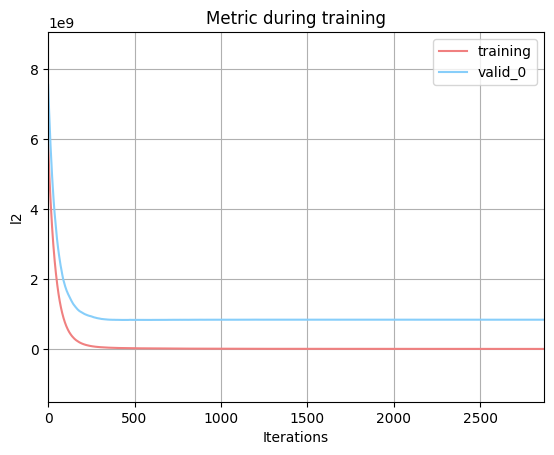

In [22]:
model = lgb.LGBMRegressor(**{
    'n_estimators': 2871,
    'reg_alpha': 0.09256633727458624,
    'reg_lambda': 1.5750906034116963,
    'colsample_bytree': 0.6,
    'subsample': 0.4,
    'learning_rate': 0.014,
    'max_depth': 10,
    'num_leaves': 511,
    'min_child_samples': 4,
    'min_data_per_groups': 57})
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.20)
model.fit(X_train, y_train, eval_set=[(X_val, y_val), (X_train, y_train)])
lgb.plot_metric(model)

# パラメータチューニング（時間がかかるのでやらない方が良いかも）

In [23]:
def objective(trial):
    all_data_fe = all_data.copy()

    # feature engineering
    all_data_fe =feature_engineering(all_data_fe)

    # get list of column types
    categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
    skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols)

    # define preprocessor
    numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=0.001, strategy="mean"))])
    skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=0.001, strategy="mean")), ("power", PowerTransformer(method='yeo-johnson'))])
    categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OrdinalEncoder())])
    preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

    # get preprocessed data
    all_data_preprocessed = pd.DataFrame(preprocessor.fit_transform(all_data_fe), columns=get_feature_names(preprocessor))
    all_data_preprocessed[target] = list(all_data_fe[target])

    # split the preprocessed data to train_X, train_y, test_X
    train_X, train_y, test_X = split_data(all_data_preprocessed, target)

    # Evaluate model
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    param = {
        'metric': 'neg_root_mean_squared_error',
        'random_state': 48,
        'n_estimators':trial.suggest_int('n_estimators', 10, 10000),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = lgb.LGBMRegressor(**param)

    scores = cross_validate(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
    score = mean(scores["test_score"])

    return score

## tfdf test

In [60]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

## tfdf 用のトレーニングデータと評価用データの作成

In [84]:
train_ds_pd = pd.concat([X_train, y_train], axis = 1)
valid_ds_pd = pd.concat([X_val, y_val], axis = 1)

In [85]:
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

## tfdfで使用できる全てのアルゴリズムをリスト形式で出力

In [63]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

### rondom forest を選択

In [64]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"]) # Optional, you can use this to include a list of eval metrics

Use /tmp/tmpy8ja20t5 as temporary training directory


### 学習させる

In [87]:
rf.fit(x=train_ds)

Reading training dataset...


Training dataset read in 0:00:01.029854. Found 1168 examples.
Training model...
Model trained in 0:00:01.070642
Compiling model...
Model compiled.


### ツリー構造の可視化

- tree_idx; ツリーの可視化を開始するノードの番号。0だと、一番最初から可視化する。
- max_depth; 木をどこまで可視化するか

In [88]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=5)

- make_inspector()
- https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/inspector/make_inspector

In [89]:
rf.make_inspector().variable_importances()

{'NUM_AS_ROOT': [("skew__TotalSF" (1; #86), 7.0),
  ("num__OverallQual" (1; #57), 6.0)],
 'SUM_SCORE': [("skew__TotalSF" (1; #86), 16683252957232.0),
  ("num__OverallQual" (1; #57), 7255938532984.0),
  ("skew__BsmtFinSF1" (1; #68), 887567580512.0),
  ("num__Total_Home_Quality" (1; #58), 762227774216.0),
  ("num__YearSinceRemodel" (1; #61), 493431292248.0),
  ("num__GarageCars" (1; #50), 473845088560.0),
  ("cat__GarageFinish" (1; #21), 374938881644.0),
  ("num__YearBuilt" (1; #59), 351376602268.0),
  ("skew__GrLivArea" (1; #74), 282169835412.0),
  ("cat__KitchenQual" (1; #27), 275857214104.0),
  ("skew__LotArea" (1; #76), 256154079160.0),
  ("skew__TotRmsAbvGrd" (1; #84), 247689865088.0),
  ("num__GarageArea" (1; #49), 218390987664.0),
  ("skew__BsmtUnfSF" (1; #72), 213760183570.0),
  ("skew__WoodDeckSF" (1; #87), 97450539492.0),
  ("num__YearRemodAdd" (1; #60), 93899122146.0),
  ("cat__Neighborhood" (1; #36), 78147307440.0),
  ("cat__LandSlope" (1; #29), 75912077440.0),
  ("cat__BsmtQ

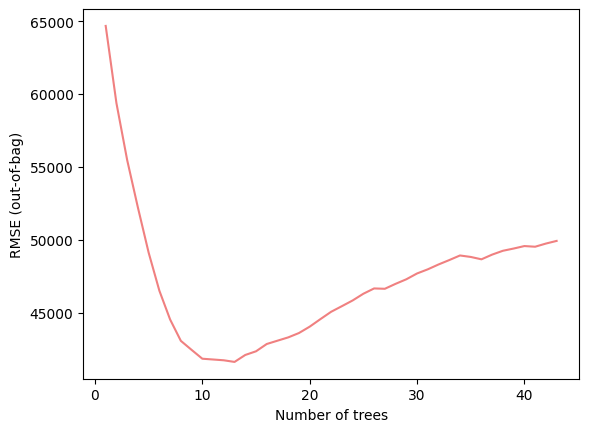

In [90]:
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [91]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=None, accuracy=None, loss=41621.453125, rmse=41621.453125, ndcg=None, aucs=None, auuc=None, qini=None)

- Randomforest 28496

In [70]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 523ms/step - loss: 0.0000e+00 - mse: 1060744960.0000
loss: 0.0000
mse: 1060744960.0000


In [71]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 NUM_NODES
	 NUM_AS_ROOT
	 SUM_SCORE


In [72]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("num__OverallQual" (1; #57), 82.0),
 ("skew__TotalSF" (1; #86), 82.0),
 ("num__GarageCars" (1; #50), 42.0),
 ("cat__ExterQual" (1; #13), 27.0),
 ("skew__GrLivArea" (1; #74), 22.0),
 ("num__GarageArea" (1; #49), 13.0),
 ("num__YearSinceRemodel" (1; #61), 9.0),
 ("skew__TotalBsmtSF" (1; #85), 9.0),
 ("num__YearBuilt" (1; #59), 6.0),
 ("cat__BsmtQual" (1; #7), 5.0),
 ("skew__1stFlrSF" (1; #65), 2.0),
 ("num__GarageYrBlt" (1; #51), 1.0)]

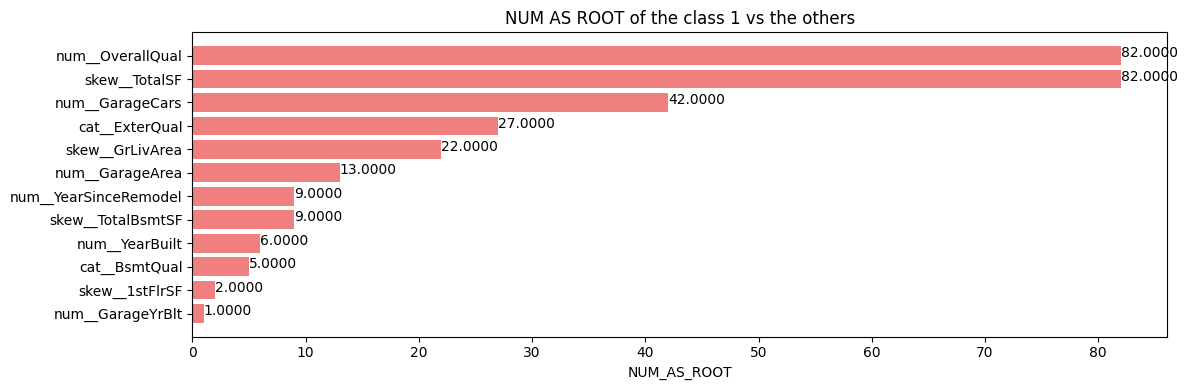

In [73]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

### 重要度変数の可視化

In [56]:
test

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


### Id


In [74]:
train_X, train_y, test_X = split_data(all_data_preprocessed, target)

In [76]:
test_X

,num__Id,num__HasWoodDeck,num__YearBuilt,num__GarageArea,num__Total_Home_Quality,num__Fireplaces,num__GarageCars,num__BsmtFullBath,num__YrSold,num__OverallQual,...,skew__1stFlrSF,skew__BsmtFinSF1,skew__GrLivArea,skew__TotalBsmtSF,skew__BsmtUnfSF,skew__BsmtFinType1_Unf,skew__2ndFlrSF,skew__TotRmsAbvGrd,skew__hasgarage,skew__hasbsmt
1460,0.001187,-1.044497,-0.340510,1.194138,-0.381773,-0.924311,-1.006994,-0.818929,1.678860,-0.772552,...,-0.662446,0.315251,-1.448234,-0.344042,-0.621459,-0.642910,-0.845474,-0.967861,0.241576,0.169996
1461,0.002373,-1.044497,-0.439565,-0.747149,0.202291,-0.924311,-1.006994,-0.818929,1.678860,-0.063185,...,0.617303,1.143440,-0.216318,0.700253,-0.187923,-0.642910,-0.845474,-0.185639,0.241576,0.169996
1462,0.003560,-1.044497,0.848148,0.042369,-0.965836,0.623632,0.306418,-0.818929,1.678860,-0.772552,...,-0.546801,0.939006,0.438288,-0.228096,-1.099587,-0.642910,1.078823,-0.185639,0.241576,0.169996
1463,0.004747,-1.044497,0.881166,-0.013362,0.202291,0.623632,0.306418,-0.818929,1.678860,-0.063185,...,-0.553938,0.601262,0.390249,-0.233099,-0.442410,-0.642910,1.048056,0.470098,0.241576,0.169996
1464,0.005934,0.957399,0.683057,0.153831,0.786355,-0.924311,0.306418,-0.818929,1.678860,1.355551,...,0.502149,-0.236297,-0.339877,0.593748,1.100435,-0.642910,-0.845474,-0.967861,0.241576,0.169996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,1.726711,0.957399,-0.043346,-2.196149,-0.381773,-0.924311,-2.320407,-0.818929,-1.363569,-1.481920,...,-2.114688,-1.147034,-0.852874,-1.238932,0.195422,1.557144,0.849249,-0.967861,-4.148262,0.169996
2915,1.727897,0.957399,-0.043346,-0.867899,-1.549900,-0.924311,-1.006994,-0.818929,-1.363569,-1.481920,...,-2.114688,-0.269972,-0.852874,-1.238932,-0.540780,-0.642910,0.849249,-0.185639,0.241576,0.169996
2916,1.729084,-1.044497,-0.373528,0.478927,0.202291,0.623632,0.306418,1.087334,-1.363569,-0.772552,...,0.363064,1.544366,-0.486369,0.470093,-1.644820,-0.642910,-0.845474,0.470098,0.241576,0.169996
2917,1.730271,-1.044497,0.683057,-2.196149,-0.965836,-0.924311,-2.320407,-0.818929,-1.363569,-0.772552,...,-0.399789,-0.020308,-1.216580,-0.268218,0.266316,-0.642910,-0.845474,-0.185639,-4.148262,0.169996


In [78]:
# ids = test.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_X,
    task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.head()

2/2 [==============================] - 0s 26ms/step


,Id,SalePrice
0,1461,127378.937500
1,1462,157178.734375
2,1463,175924.437500
3,1464,183326.375000
4,1465,193010.390625


In [81]:
submission["SalePrice"] = output.SalePrice

In [82]:
submission

,Id,SalePrice
0,1461,127378.937500
1,1462,157178.734375
2,1463,175924.437500
3,1464,183326.375000
4,1465,193010.390625
...,...,...
1454,2915,90138.781250
1455,2916,88379.468750
1456,2917,160826.703125
1457,2918,120412.039062


In [83]:
submission.to_csv("/content/drive/MyDrive/Colab Notebooks/kaggle/submission_tfdf.csv", index = False)

## スコア提出
0.14168

In [26]:
X_train, X_val, y_train, y_val

ModuleNotFoundError: ignored

In [24]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name='churn model',
                            direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

  0%|          | 0/50 [00:00<?, ?it/s]

[W 2023-06-24 02:13:18,332] Trial 2 failed with parameters: {'n_estimators': 3695, 'reg_alpha': 2.732810796466403, 'reg_lambda': 0.024594067212672332, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 403, 'min_child_samples': 33, 'min_data_per_groups': 2} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-23-ae72dabd6a32>", line 43, in objective
    scores = cross_validate(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 266, in cross_validate
    results = parallel(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/para

KeyboardInterrupt: ignored

In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
study.best_params

In [ ]:
model = lgb.LGBMRegressor(**study.best_params)

### 提出する(Score: 0.13308)※改善しなかった


In [ ]:
submit_results(model, train_X, train_y)

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
score = -27060.674809071865


,Id,SalePrice
0,1461,126570.780214
1,1462,161669.189050
2,1463,180485.228982
3,1464,186236.777754
4,1465,189396.654412
...,...,...
1454,2915,81169.531730
1455,2916,82731.459333
1456,2917,160795.808887
1457,2918,115582.214196
